In [1]:
from typing import cast

import numpy as np
from sklearn.manifold import MDS
import matplotlib.pyplot as plt
import matplotlib

import ffutils as ff
import machines
from pdfa import PDFA
import variety as var
from ffutils import Model, TestConfig, TrainRun, TestRun, ModelType, EnsMode, VoteStrat
from export import import_pdfa_json
from clock import SimpleClock
from cache import Cache

# === GLOBAL OBJECTS ===

CORES = 12
CLOCK = SimpleClock()
CACHE = Cache()

STANDARD_TEST = ff.create_standard_config("test")
REBER_CONFIG = ff.create_standard_config("reber")
PARITY_CONFIG = ff.create_standard_config("parity")

def PAUTOMAC_SET(set_number: int):
    return TestConfig(
        name = f"pautomac_{set_number}",
        dir = "PAutomaC-competition_sets",
        train_suffix = ".pautomac.train.dat",
        model_suffix = ".pautomac.train.dat.ff",
        solution_suffix = ".pautomac_solution.txt",
        test_suffix = ".pautomac.test.dat"
    )

def RANDOM_CONFIG(id: int) -> TestConfig:
    return ff.create_standard_config(f"random_{id}", dir="random")

def RANDOM_MACHINE(id: int) -> PDFA:
    return import_pdfa_json(input_file=f"./../models/random_{id}.json")

In [2]:
def scores_flat_to_distance_matrix(scores_flat: list[float], n: int) -> np.ndarray:

    # Get the sample cross entropy matrix
    C = np.array(scores_flat, dtype=float).reshape((n, n))
    print(C)

    # Now compute the Distance matrix
    D = np.zeros((n, n))
    for i in range(n):
        for j in range(i):
            dist = var.compute_distance(C, i, j)
            D[i, j] = dist
            D[j, i] = dist
    return D

In [3]:
def plot_nodes_by_distance(
        scores_flat: list[float], 
        num_models: int, 
        series: list[tuple[str, int]], 
        trainset: str, 
        print_distances=False
    ):

    distance_matrix = var.scores_flat_to_distance_matrix_gao(scores_flat, num_models)
    if print_distances:
        np.set_printoptions(threshold=100000, linewidth=100000)
        print(distance_matrix)

    # reducer = UMAP(metric='precomputed', random_state=42, min_dist=0.0)
    # print(reducer.fit_transform(distance_matrix))
    # coords: np.ndarray = cast(np.ndarray, reducer.fit_transform(distance_matrix))

    reducer = MDS(n_components=2, dissimilarity="precomputed", metric=True, random_state=42)
    coords = reducer.fit_transform(distance_matrix)
    print(coords)

    # Plot each group in the series
    plt.figure(figsize=(10, 8))
    tot = 0
    for label, size in series:
        indices = [i for i in range(tot, tot + size)]
        tot += size
        subset = coords[indices]
        plt.scatter(subset[:, 0], subset[:, 1], s=150, label=label, alpha=0.5, linewidths=2, zorder=100-tot)  # s=100 makes points bigger
        # for i in indices:
        #     plt.text(coords[i, 0], coords[i, 1], str(i - min(indices)), fontsize=9, ha='center', va='center')

    plt.title(f"Model Similarities via MDS: {trainset}")
    plt.legend()
    plt.tight_layout()
    plt.show()


def runs_into_series(runs: list[TrainRun]) -> list[tuple[str, int]]:
    series = []
    for run in runs:
        if run.model.model_type == ModelType.SINGLE:
            series.append((run.run_name, 1))
        else:
            series.append((run.run_name, run.model.nrestimators))
    return series

def total_models(series: list[tuple[str, int]]) -> int:
    model_count = 0
    for _, models in series:
        model_count += models
    return model_count

[[0.         0.         0.         0.         0.25727107 0.         0.         0.         0.         0.         0.         0.         0.         0.24317547 0.18849923 0.         0.24877036 0.         0.         0.         0.         0.65087008 0.82205109 0.72614187 0.50333267 1.2678158  0.63359835 0.68673081 1.60716587 1.63191599 0.56107412 0.47777301 0.84056282 0.69580311 0.41759893 1.7006552  0.38792281 0.42032544 0.63724897 0.52238398 1.1845083 ]
 [0.         0.         0.         0.         0.26334625 0.         0.         0.         0.         0.         0.         0.         0.         0.249049   0.18515054 0.         0.25468351 0.         0.         0.         0.         0.6597607  0.82634097 0.73843183 0.51094593 1.26955238 0.64510969 0.69541393 1.62921504 1.65184261 0.5660204  0.48222034 0.85217154 0.7116937  0.4274623  1.72076847 0.40325695 0.41360877 0.64835559 0.53393274 1.20412107]
 [0.         0.         0.         0.         0.27941331 0.         0.         0.         0.

c:\Users\blaze\Projects\FlexFringeUtils\.venv\Lib\site-packages\sklearn\manifold\_mds.py:677: FutureWarning: The default value of `n_init` will change from 4 to 1 in 1.9.
  warnings.warn(


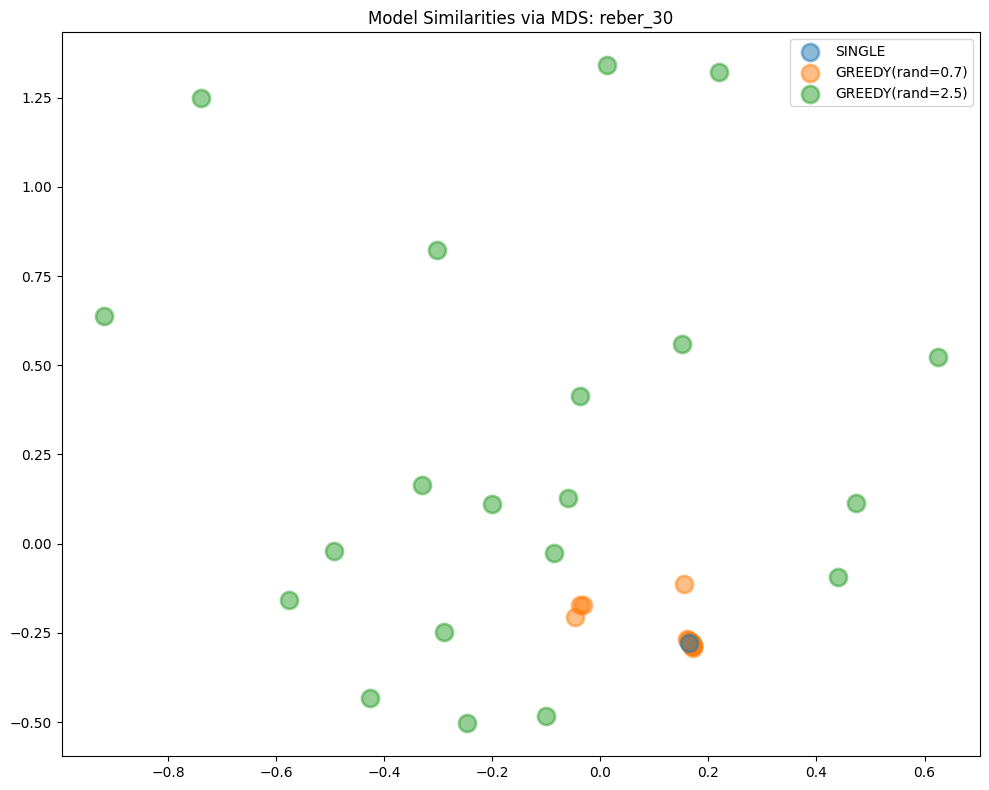

In [46]:
def plot_models_diff_reber(skip_train = False):

    config = ff.create_standard_config(dir="reber", test_name="dist")
    trainset_name = "reber_30"
    ff.write_trainset(config, machines.reber(), trainset_name, 25)
    nrestimators = 20

    models = [
        Model.Single("SINGLE"),
        Model.Greedy("GREEDY(rand=0.7)", nrestimators=nrestimators, rand=0.7),
        Model.Greedy("GREEDY(rand=2.5)", nrestimators=nrestimators, rand=2.5)
    ]
    train_runs = []
    for model in models:
        train_runs.append(model.into_run(trainset_name=trainset_name))
    if not skip_train:
        ff.train_models_batch(config, train_runs)
    scores_flat = ff.diff_models(config, trainset_name, [model.model_file for model in models], nrestimators=nrestimators, sample_size=400)
    series = runs_into_series(train_runs)

    plot_nodes_by_distance(scores_flat, total_models(series), series, trainset=trainset_name, print_distances=True)

plot_models_diff_reber(skip_train=False)

Running command: ['C:\\users\\blaze\\Projects\\FlexFringeEnsemble\\cmake-build-debug-visual-studio\\flexfringe.exe', '--mode', 'inter_model', '--ini', 'C:\\users\\blaze\\Projects\\FlexFringeEnsemble\\ini\\alergia.ini', '--samsize', '500', '--aptafile', 'C:\\users\\blaze\\Projects\\FlexFringeEnsemble\\data\\random\\out_diff_random_1\\DIFF_SIN_training.txt;C:\\users\\blaze\\Projects\\FlexFringeEnsemble\\data\\random\\out_diff_random_1\\DIFF_GREEDY_training.txt', '--nrestimators', '15', '--votestrat', 'weighted', 'C:\\users\\blaze\\Projects\\FlexFringeEnsemble\\data\\random\\random_1_350_training.txt']
Using heuristic alergia
Using input file: C:\users\blaze\Projects\FlexFringeEnsemble\data\random\random_1_350_training.txt
Creating apta using evaluation class alergia
Inter model variety mode selected
Loading single model from file: C:\users\blaze\Projects\FlexFringeEnsemble\data\random\out_diff_random_1\DIFF_SIN_training.txt.final.json
Could not load single model: C:\users\blaze\Projects\

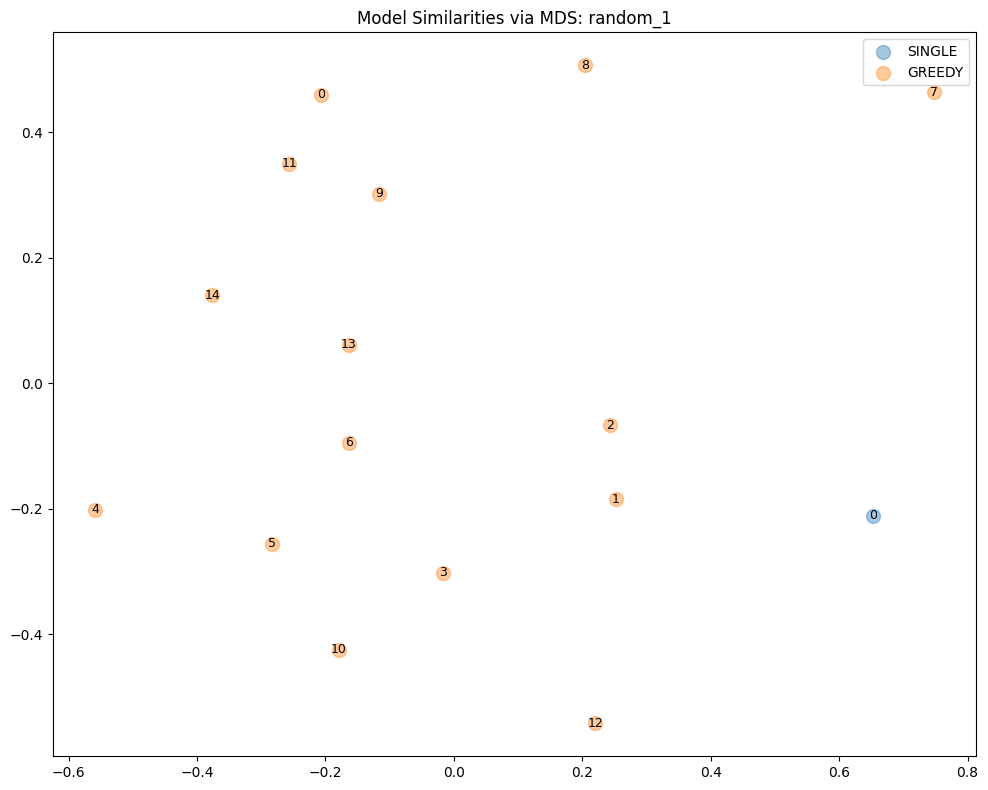

In [66]:

def plot_models_diff_random_1(skip_train = False):

    config = ff.create_standard_config(dir="random", test_name="diff_random_1")
    ens_size = 15
    trainset_name = "random_1_350"
    ff.write_trainset(config, RANDOM_MACHINE(1), trainset_name, 350)

    single = Model.Single("DIFF_SIN")
    ensemble = Model.Greedy("DIFF_GREEDY", nrestimators=ens_size, rand=2.5)
    models = [single, ensemble]

    if not skip_train:
        runs = []
        runs.append(single.into_run(trainset_name=trainset_name))
        runs += ensemble.split_into_parallel_runs(trainset_name=trainset_name)
        ff.train_models_batch(config, runs)

    scores_flat = ff.diff_models(config, trainset_name, [m.model_file for m in models], nrestimators=ens_size, sample_size=500)

    series = [
        ("SINGLE", 1),
        ("GREEDY", ens_size)
    ]
    model_count = total_models(series)
    plot_nodes_by_distance(scores_flat, model_count, series=series , trainset="random_1", print_distances=True)

plot_models_diff_random_1(skip_train=True)

In [ ]:

def plot_models_diff_random_1():

    random_config = ff.create_standard_config("random_1", dir="random")

    trainset_a = "random_1_400" # SINGLE performs really well here
    trainset_b = "random_1_450" # Single performs really bad here

    models = [
        Model.Single("DIFF_SIN"),
        Model.Greedy("DIFF_GREEDY", nrestimators=15, rand=2.5)
    ]

    runs = []
    # Train models with good data
    for model in models:
        run = model.into_run(trainset_name=trainset_a, run_name="good")
        runs.append(run)
    # Train models with bad data
    for model in models:
        run = model.into_run(trainset_name=trainset_b, run_name="bad")
        runs.append(run)

    ff.train_models_batch(random_config, runs)
    scores_flat = ff.diff_models(random_config, trainset_a, [run.run_name for run in runs], nrestimators=10, sample_size=200)

    series = runs_into_series(runs)
    model_count = total_models(series)
    plot_nodes_by_distance(scores_flat, model_count, series=series , trainset="random_1 good vs bad", print_distances=True)

plot_models_diff_random_1()